# kaggle Vesuvius Challenge - Ink Detection 6 th training quick start and example code for google colab
This notebook is designed to facilitate the execution of training code for the Kaggle Vesuvius Challenge.


th 0.96, cv 0.740, public LB 0.81, private LB 0.66

| model                     | image size | kfold         | cv     | public LB | private LB | usemodels(kfold) for inference |
|---------------------------|------------|---------------|--------|-----------|------------|-------------------------------|
| efficientnet_b7_ns        | 608        | 7 + fulltrain | 0.712  | 0.80      | 0.64       | [4,5,6,10,11,12,13,14]        |
| efficientnet_b6_ns        | 544        | 7 + fulltrain | 0.702  | 0.79      | 0.64       | [4,5,6,10,11,12,13,14]        |
| efficientnetv2_l_in21ft1k | 480        | 7             | 0.707  | 0.79      | 0.65       | [4,5,6,11,12,13,14]           |
| tf_efficientnet_b8        | 672        | 7             | 0.716  | 0.79      | 0.64       | [4,5,6,11,12,13,14]           |
| segformer b3              | 1024       | 7             | 0.738  | 0.78      | 0.66       | [4,5,6,11,12,13,14]           |



# About environment

I created the efficientnetv2_l_in21ft1k model using Google Colab Pro+ with a V100 GPU and high memory, while the other models were created using A100 GPUs with high memory.

# 0.Setting

## 0.1 Clone my repository

In [1]:
!git clone https://github.com/chumajin/kaggle-VCID.git

Cloning into 'kaggle-VCID'...


## 0.2 mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 0.3 install adder libraries

### 0.3.1 add libraries (not using requirement.txt)

In [ ]:
!pip install transformers==4.29.2
!pip install timm==0.9.2
!pip install segmentation_models_pytorch==0.3.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientne

# 1.DataPreparation


The input data is required to have the following structure.

~~~
input_path
    └── fragmentid
        ├── subvolume
        │   ├── 1.tif
        │   ├── 2.tif
        │   ├── 3.tif
        │   ├── ・・・
        │   └── 64.tif
        ├── mask.png
        ├── ir.png
        └── inklabels.png
~~~

If you want to use the competition data, you can download the compressed data using the Kaggle API through your kaggle.json file.

~~~
import os
import json

kaggle_path = "***/kaggle.json" # you must change this for your own
f = open(kaggle_path, 'r')
json_data = json.load(f)
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

## download dataset

!kaggle datasets download -d chumajin/vcid-light-dataset
!unzip vcid-light-dataset.zip
~~~

If you use an original data, you set the input_path as above.
Afterwards, it will be compressed to uint8 format using preprocess.py.
Note that, this overwrites the images in input_path.
In the competition, the data was compressed to uint8 format, but the accuracy difference is not significant, so preprocessing may not be necessary if you did not.

~~~
python preprocess.py \
--inputpath input_path
~~~


In [ ]:
import os
import json

kaggle_path = "/content/drive/My Drive/kaggle/kaggle.json" # you must change this for your own
f = open(kaggle_path, 'r')
json_data = json.load(f)
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

## download dataset

!kaggle datasets download -d chumajin/vcid-light-dataset
os.makedirs("train",exist_ok=True)
!unzip vcid-light-dataset.zip -d train

100% 8.35G/8.36G [01:18<00:00, 153MB/s]
100% 8.36G/8.36G [01:18<00:00, 115MB/s]
Archive:  vcid-light-dataset.zip
  inflating: train/1/inklabels.png   
  inflating: train/1/inklabels_rle.csv  
  inflating: train/1/ir.png          
  inflating: train/1/mask.png        
  inflating: train/1/surface_volume/00.tif  
  inflating: train/1/surface_volume/01.tif  
  inflating: train/1/surface_volume/02.tif  
  inflating: train/1/surface_volume/03.tif  
  inflating: train/1/surface_volume/04.tif  
  inflating: train/1/surface_volume/05.tif  
  inflating: train/1/surface_volume/06.tif  
  inflating: train/1/surface_volume/07.tif  
  inflating: train/1/surface_volume/08.tif  
  inflating: train/1/surface_volume/09.tif  
  inflating: train/1/surface_volume/10.tif  
  inflating: train/1/surface_volume/11.tif  
  inflating: train/1/surface_volume/12.tif  
  inflating: train/1/surface_volume/13.tif  
  inflating: train/1/surface_volume/14.tif  
  inflating: train/1/surface_volume/15.tif  
  inflating:

# 2.Select model and fold

In this notebook, you can create a model for a single fold of the 1Model approach. Please specify the model and fold you would like to use.

| model                     | image size | kfold         | cv     | public LB | private LB | usemodels(kfold) for inference |
|---------------------------|------------|---------------|--------|-----------|------------|-------------------------------|
| efficientnet_b7_ns        | 608        | 7 + fulltrain | 0.712  | 0.80      | 0.64       | [4,5,6,10,11,12,13,14]        |
| efficientnet_b6_ns        | 544        | 7 + fulltrain | 0.702  | 0.79      | 0.64       | [4,5,6,10,11,12,13,14]        |
| efficientnetv2_l_in21ft1k | 480        | 7             | 0.707  | 0.79      | 0.65       | [4,5,6,11,12,13,14]           |
| tf_efficientnet_b8        | 672        | 7             | 0.716  | 0.79      | 0.64       | [4,5,6,11,12,13,14]           |
| segformer-b3              | 1024       | 7             | 0.738  | 0.78      | 0.66       | [4,5,6,11,12,13,14]           |



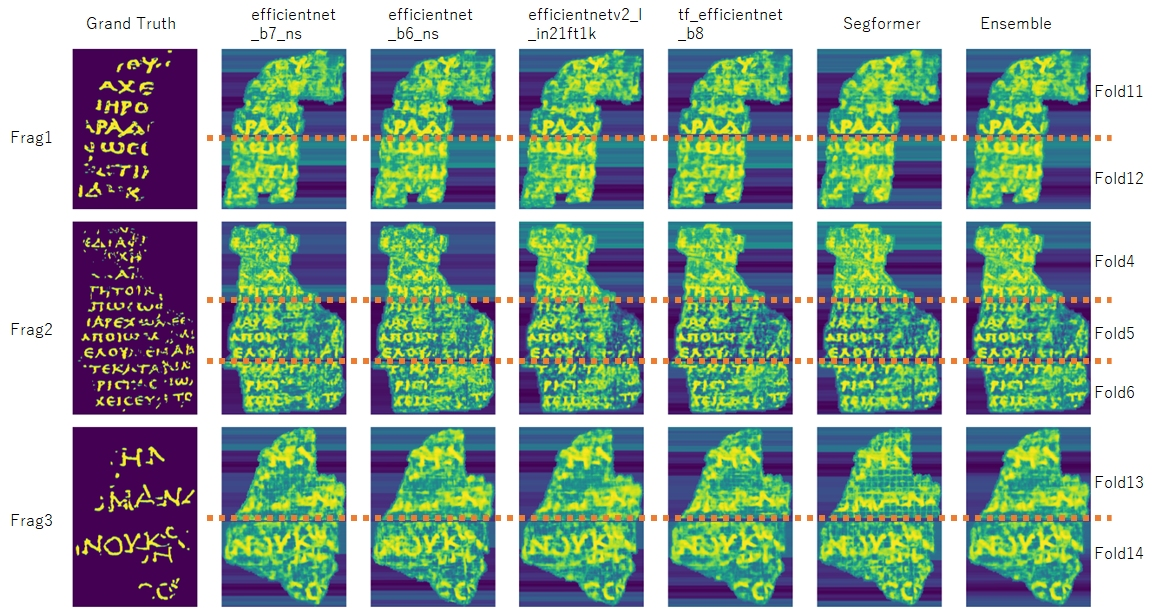

# 3.Execute training

The model will be created inside the savepath as 'model{fold}.pth'.Since data can be lost if the Google Colab session is disconnected, it is recommended to save the data in Google Drive. If you provide a folder name, a folder will be created automatically.

In [ ]:
!python ./kaggle-VCID/train.py \
--model efficientnet_b7_ns \
--fold 14 \
--savepath output \
--inputpath train

2023-06-26 17:50:33.372965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Namespace(model='efficientnet_b7_ns', fold=14, savepath='output', inputpath='train', num_workers=8, changelr=False, lr=1e-05, changebatch=False, trainbatch=4, validbatch=8, originalvalidid=1, shutdown=False)
--------------------------------------------------
model training start : model efficientnet_b7_ns, fold 14, lr 0.003, train_batch 16, valid_batch 32
--------------------------------------------------
[28, 30, 32]
['1', '2', '3']
100% 6/6 [00:05<00:00,  1.15it/s]
100% 6/6 [00:15<00:00,  2.53s/it]
100% 6/6 [00:04<00:00,  1.37it/s]
8090
['1', '2', '3']
100% 6/6 [00:05<00:00,  1.14it/s]
100% 6/6 [00:15<00:00,  2.52s/it]
100% 6/6 [00:04<00:00,  1.37it/s]
['1', '2', '3']
100% 6/6 [00:05<00:00,  1.16it/s]
100% 6/6 [00:15<00:00,  2.50s/it]
100% 6/6 [00:04<00:00,  1.40it/s]
['1', '2', '3']
100% 6/6 [00:02<00:00,  2.04it/s]
100% 6/6 [00:08<00:00,  1.43s/it]
100% 6/6 [0

#### This is the result example of output.

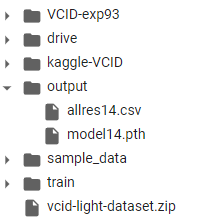